<a href="https://colab.research.google.com/github/gabilodeau/INF6804/blob/master/Zero_Shot_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### INF8225 - Intelligence artificielle : techniques probabilistes et d’apprentissage

**Polytechnique Montréal**  
**Auteurs :** Xavier Chalifoux et Guillaume Prégent

**Description :** Ce notebook présente BLA BLA BLA


## 1. Imports

In [1]:
!pip install wandb


In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from torch.utils.data import DataLoader, Dataset
import os
import cv2
from PIL import Image
import wandb
from collections import defaultdict
import time
import random

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Downloading Dataset

In [3]:

os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d /content/chest_xray

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  chest-xray-pneumonia.zip
replace /content/chest_xray/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/chest_xray/chest_xray/__MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/chest_xray/chest_xray/__MACOSX/chest_xray/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Finalement, j'ai meme pas utilisé ça

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    labels_list = []  # Store labels separately
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                data.append(resized_arr)  # Append only the image data
                labels_list.append(class_num)  # Append the corresponding label
            except Exception as e:
                print(f"Error loading image {img}: {e}")

    return np.array(data), np.array(labels_list)

In [3]:
# Ca prends quelques minutes...
print("Fetching Training data...")
x_train, y_train = get_training_data('chest_xray/chest_xray/chest_xray/train')

print("Fetching Testing data...")
x_test, y_test = get_training_data('chest_xray/chest_xray/chest_xray/test')

print("Fetching Validation data...")
x_val, y_val = get_training_data('chest_xray/chest_xray/chest_xray/val')

Fetching Training data...
Error loading image .DS_Store: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error loading image .DS_Store: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Fetching Testing data...
Fetching Validation data...
Error loading image .DS_Store: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Error loading image .DS_Store: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [4]:
print("Training data shape:", x_train.shape, y_train.shape)
print("Testing data shape:", x_test.shape, y_test.shape)
print("Validation data shape:", x_val.shape, y_val.shape)

Training data shape: (5216, 150, 150) (5216,)
Testing data shape: (624, 150, 150) (624,)
Validation data shape: (16, 150, 150) (16,)


<Axes: xlabel='count'>

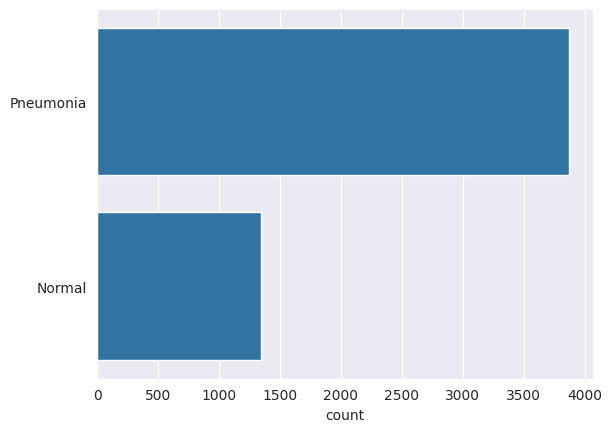

In [5]:
l = []
for i in y_train:
    if(i == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Data imbalance to handle in training data

<Axes: xlabel='count'>

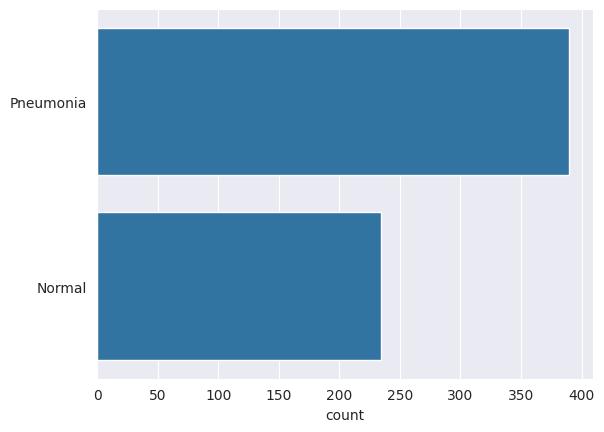

In [6]:
l = []
for i in y_test:
    if(i == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

<Axes: xlabel='count'>

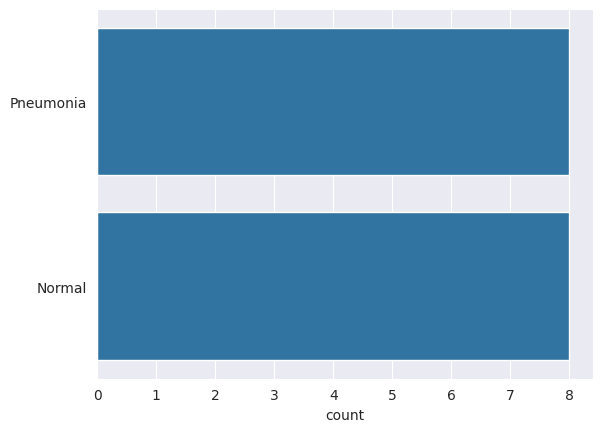

In [7]:
l = []
for i in y_val:
    if(i == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

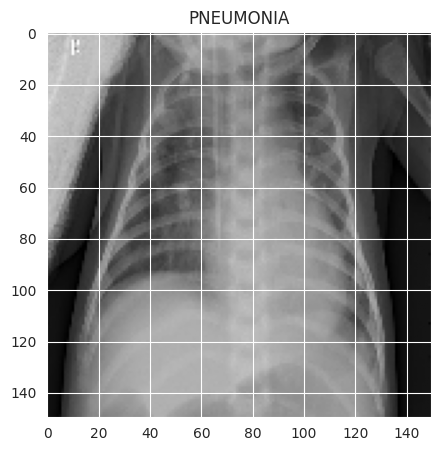

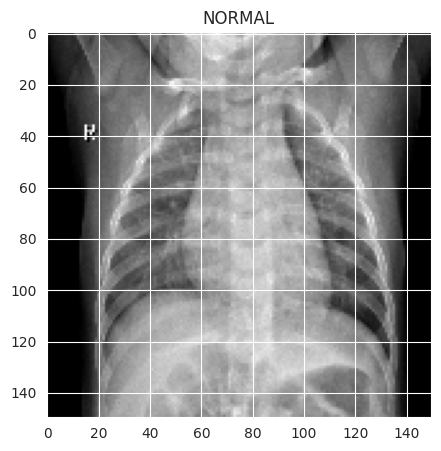

In [8]:
plt.figure(figsize = (5,5))
plt.imshow(x_train[0], cmap='gray')
plt.title(labels[y_train[0]])

plt.figure(figsize = (5,5))
plt.imshow(x_train[-1], cmap='gray')
plt.title(labels[y_train[-1]])

In [9]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [10]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

On pourrait ou non faire du data augmentation pour équilibrer pneumonie ou non

## 3. Utility functions for training

In [19]:

# Function to display 3 images on the same line
def display_images(images, predicted_labels, actual_labels):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns
    for i, ax in enumerate(axes):
        image = images[i].permute(1, 2, 0).cpu().numpy()  # Convert from Tensor (C, H, W) to (H, W, C)
        image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1 for visualization
        ax.imshow(image)
        pred_label = "Pneumonia" if predicted_labels[i].item() == 0 else "Normal"
        actual_label = "Pneumonia" if actual_labels[i].item() == 0 else "Normal"
        ax.set_title(f'Pred: {pred_label}, Actual: {actual_label}')
        ax.axis('off')
    print(f"\nPredictions examples on validation set:")
    plt.show()

def print_logs(dataset_type: str, logs: dict):
    desc = '\t'.join([f'{name}: {value:.4f}' for name, value in logs.items()])
    print(f'{dataset_type} -\t{desc}'.expandtabs(5))

def eval_model(model: nn.Module, dataloader: DataLoader, config: dict) -> dict:
    device = config['device']
    logs = defaultdict(list)
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            logs['val_loss'].append(loss.cpu().item())

            # Collect predictions and labels for F1 calculation
            preds = torch.sigmoid(outputs).round()  # Sigmoid and round to get binary predictions
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate F1 score, etc.
    f1 = f1_score(all_labels, all_preds)
    logs['val_f1_score'] = f1

    return {name: np.mean(values) for name, values in logs.items()}

def train_model(model: nn.Module, config: dict):
    train_loader, val_loader = config['train_loader'], config['val_loader']
    optimizer = config['optimizer']
    clip = config['clip']
    device = config['device']

    start_time = time.time()  # Start time for total training

    print(f'Starting training for {config["epochs"]} epochs on {device}.')
    for epoch in range(config['epochs']):
        epoch_start_time = time.time()  # Start time for each epoch
        print(f'\nEpoch {epoch+1}')

        model.train()
        logs = defaultdict(list)
        correct = 0
        total = 0
        false_positive = 0
        false_negative = 0
        images_to_display = []

        # Training loop
        for batch_id, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device).unsqueeze(1).float()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            logs['train_loss'].append(loss.cpu().item())

        epoch_end_time = time.time()  # End time for the current epoch
        epoch_duration = epoch_end_time - epoch_start_time  # Calculate epoch duration
        print(f"Time taken: {epoch_duration:.2f} seconds")

        # Now, collect 3 random images from the validation dataset to display
        model.eval()  # Set model to evaluation mode

        # Log metrics
        train_logs = {
            'train_loss': loss,
            'epoch_duration': epoch_duration
        }
        print_logs('Train', train_logs)

        val_logs = eval_model(model, val_loader, config)
        print_logs('Eval', val_logs)

        # Log everything to W&B
        wandb.log({**train_logs, **val_logs})

        with torch.no_grad():
            # Choose 3 random images from the validation set
            random_indices = random.sample(range(len(val_loader.dataset)), 3)
            images_batch = []
            predicted_labels = []
            actual_labels = []

            for idx in random_indices:
                image, label = val_loader.dataset[idx]
                image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
                output = model(image)
                pred = torch.sigmoid(output).round()

                images_batch.append(image[0])  # Remove batch dimension for display
                predicted_labels.append(pred[0])
                actual_labels.append(label)

            # Display 3 random images with predicted and actual labels
            display_images(images_batch, predicted_labels, actual_labels)


    total_training_time = time.time() - start_time  # Total training time
    print(f"\nTotal Training Time: {total_training_time:.2f} seconds")

In [12]:
class PneumoniaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        labels = ["NORMAL", "PNEUMONIA"]
        for label in labels:
            label_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(label_dir):
                if img_name == ".DS_Store":
                      continue
                img_path = os.path.join(label_dir, img_name)
                # Store labels as float32
                self.data.append((img_path, 0.0 if label == "NORMAL" else 1.0))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)  # Ensure label is float32

## 4. WandB login and GPU connection

In [16]:
!wandb login

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

wandb: Currently logged in as: xav-chalif (xav-chalif-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
Tue Mar 25 03:28:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             36W /   70W |     724MiB /  15360MiB |      0%      De

## 5. Training Models

### Pytorch ResNet with lr=0.001

In [17]:
config = {
    'epochs': 10,
    'batch_size': 32,
    'lr': 1e-3,
    'betas': (0.9, 0.99),
    'clip': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'image_size': 150,
    'dropout': 0.1,
    'seed': 42,
    'log_every': 10,
}

torch.manual_seed(config['seed'])

# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((config['image_size'], config['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define ResNet Model
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(config['dropout']),
    nn.Linear(model.fc.in_features, 1)
)
model = model.to(config['device'])

config['optimizer'] = optim.Adam(model.parameters(), lr=config['lr'], betas=config['betas'])

# Load Dataset
train_dataset = PneumoniaDataset("chest_xray/chest_xray/chest_xray/train", transform=transform)
val_dataset = PneumoniaDataset("chest_xray/chest_xray/chest_xray/test", transform=transform)

config['train_loader'] = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
config['val_loader'] = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


W&B online. Running your script from this directory will now sync to the cloud.


Starting training for 10 epochs on cuda.

Epoch 1
Time taken: 87.15 seconds
Train -   train_loss: 0.0031  epoch_duration: 87.1457
Eval -    val_loss: 1.3383    val_f1_score: 0.8033

Predictions examples on validation set:


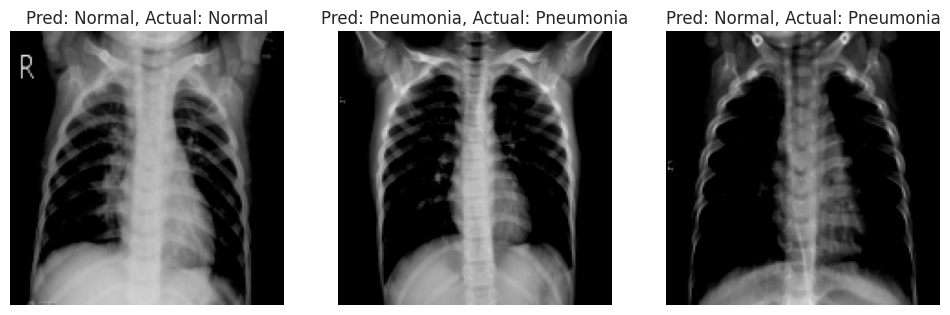


Epoch 2
Time taken: 87.63 seconds
Train -   train_loss: 0.0050  epoch_duration: 87.6321
Eval -    val_loss: 0.3607    val_f1_score: 0.9075

Predictions examples on validation set:


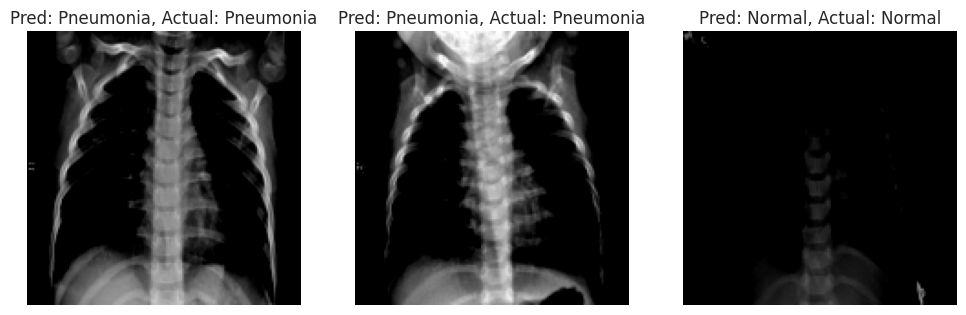


Epoch 3
Time taken: 87.25 seconds
Train -   train_loss: 0.0049  epoch_duration: 87.2457
Eval -    val_loss: 1.6031    val_f1_score: 0.8224

Predictions examples on validation set:


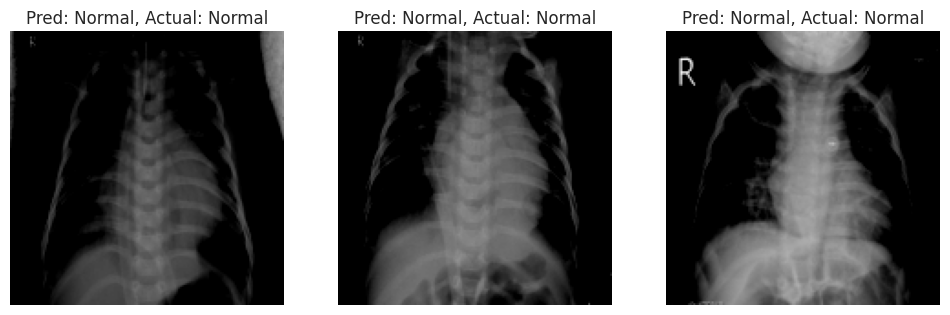


Epoch 4
Time taken: 87.59 seconds
Train -   train_loss: 0.0021  epoch_duration: 87.5884
Eval -    val_loss: 0.8638    val_f1_score: 0.8770

Predictions examples on validation set:


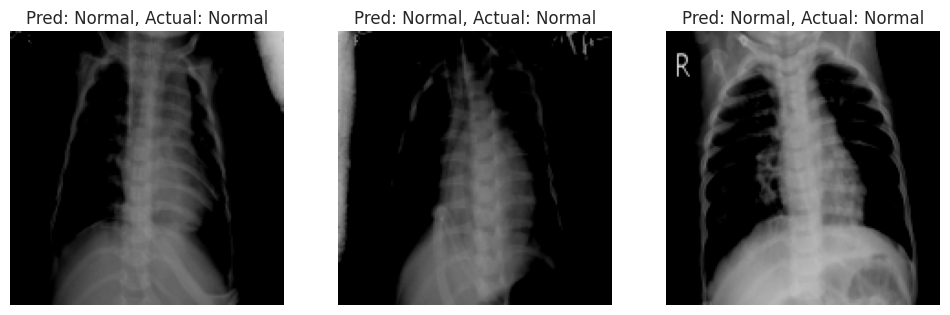


Epoch 5
Time taken: 88.42 seconds
Train -   train_loss: 0.0054  epoch_duration: 88.4190
Eval -    val_loss: 1.1946    val_f1_score: 0.8515

Predictions examples on validation set:


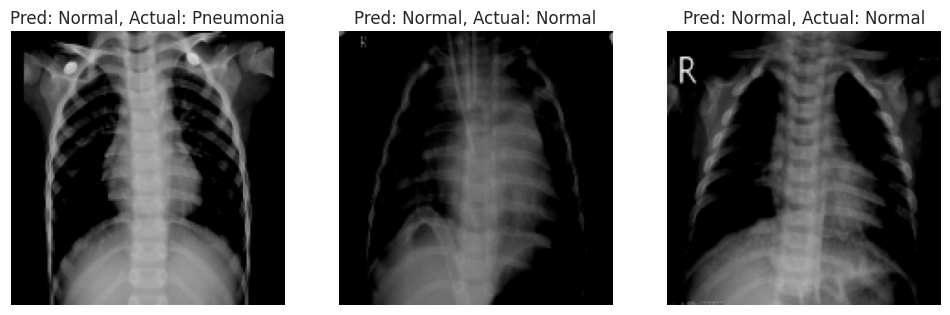


Epoch 6
Time taken: 87.23 seconds
Train -   train_loss: 0.0002  epoch_duration: 87.2278
Eval -    val_loss: 1.2232    val_f1_score: 0.8606

Predictions examples on validation set:


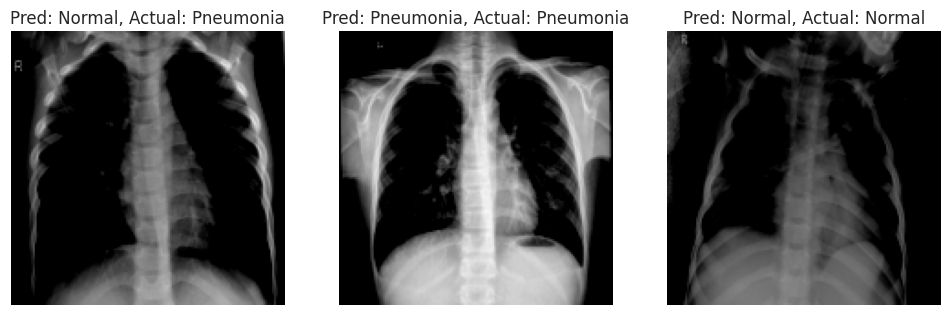


Epoch 7
Time taken: 88.86 seconds
Train -   train_loss: 0.0002  epoch_duration: 88.8611
Eval -    val_loss: 1.2646    val_f1_score: 0.8556

Predictions examples on validation set:


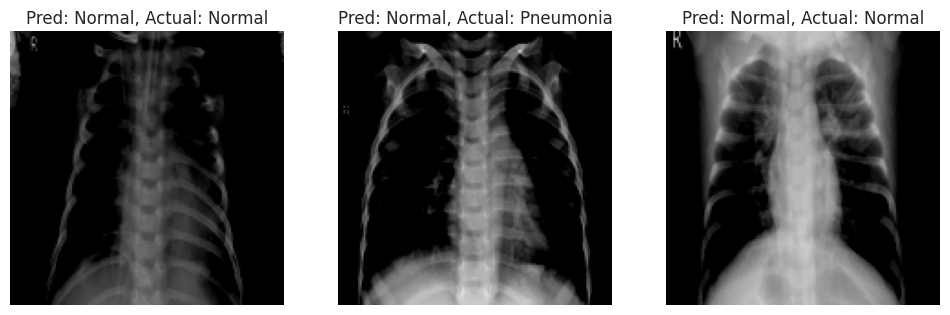


Epoch 8
Time taken: 86.74 seconds
Train -   train_loss: 0.0569  epoch_duration: 86.7360
Eval -    val_loss: 2.4025    val_f1_score: 0.8237

Predictions examples on validation set:


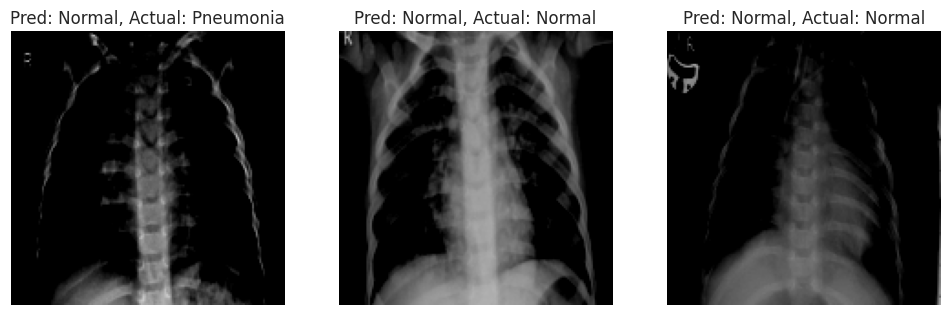


Epoch 9
Time taken: 92.49 seconds
Train -   train_loss: 0.0014  epoch_duration: 92.4940
Eval -    val_loss: 0.8088    val_f1_score: 0.8886

Predictions examples on validation set:


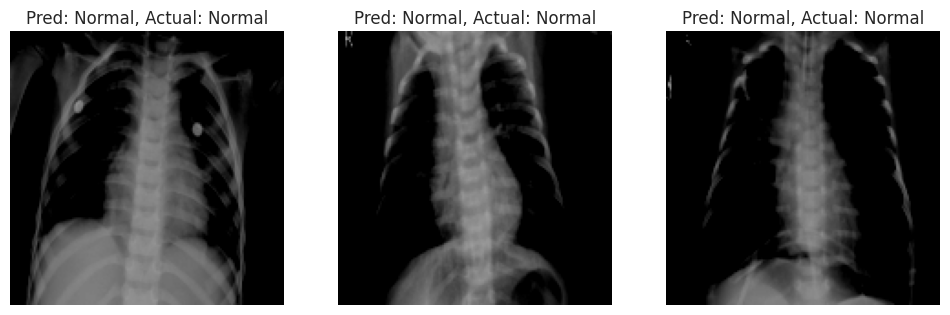


Epoch 10
Time taken: 95.66 seconds
Train -   train_loss: 0.0000  epoch_duration: 95.6597
Eval -    val_loss: 1.9675    val_f1_score: 0.8324

Predictions examples on validation set:


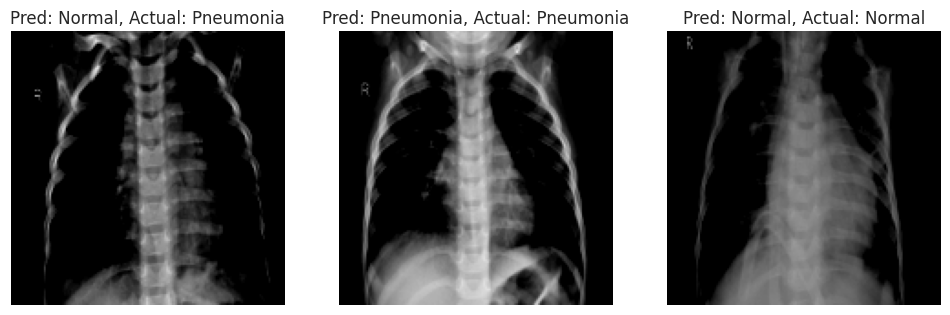


Total Training Time: 989.81 seconds


epoch_duration,▁▂▁▂▂▁▃▁▆█
train_loss,▁▂▂▁▂▁▁█▁▁
val_f1_score,▁█▂▆▄▅▅▂▇▃
val_loss,▄▁▅▃▄▄▄█▃▇
epoch_duration,95.65968
train_loss,2e-05
val_f1_score,0.83244
val_loss,1.96753


In [20]:
!wandb online  # online / offline / disabled to activate, deactivate or turn off WandB logging

with wandb.init(
        config=config,
        project='INF8225 - Projet',  # Title of your project
        group='Pytorch ResNet',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
    train_model(model, config)

### Pytorch ResNet with lr=0.00001

In [25]:
config = {
    'epochs': 10,
    'batch_size': 32,
    'lr': 1e-4,
    'betas': (0.9, 0.99),
    'clip': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'image_size': 150,
    'dropout': 0.1,
    'seed': 42,
    'log_every': 10,
}

torch.manual_seed(config['seed'])

# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((config['image_size'], config['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define ResNet Model
model = models.resnet18()
model.fc = nn.Sequential(
    nn.Dropout(config['dropout']),
    nn.Linear(model.fc.in_features, 1)
)
model = model.to(config['device'])

config['optimizer'] = optim.Adam(model.parameters(), lr=config['lr'], betas=config['betas'])

# Load Dataset
train_dataset = PneumoniaDataset("chest_xray/chest_xray/chest_xray/train", transform=transform)
val_dataset = PneumoniaDataset("chest_xray/chest_xray/chest_xray/test", transform=transform)

config['train_loader'] = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
config['val_loader'] = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()


Starting training for 10 epochs on cuda.

Epoch 1
Time taken: 89.87 seconds
Train -   train_loss: 0.0225  epoch_duration: 89.8692
Eval -    val_loss: 0.4527    val_f1_score: 0.8644

Predictions examples on validation set:


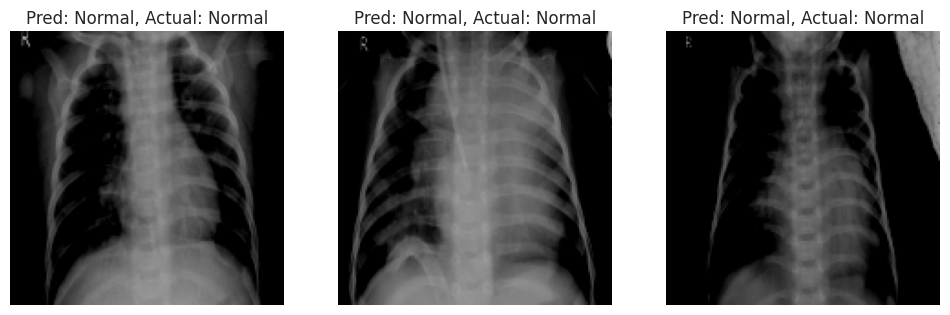


Epoch 2
Time taken: 90.45 seconds
Train -   train_loss: 0.0222  epoch_duration: 90.4452
Eval -    val_loss: 0.9544    val_f1_score: 0.8263

Predictions examples on validation set:


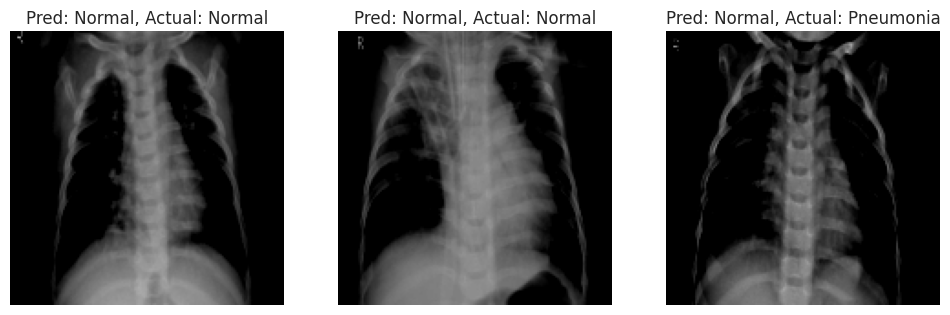


Epoch 3
Time taken: 87.92 seconds
Train -   train_loss: 0.0109  epoch_duration: 87.9165
Eval -    val_loss: 0.8945    val_f1_score: 0.8610

Predictions examples on validation set:


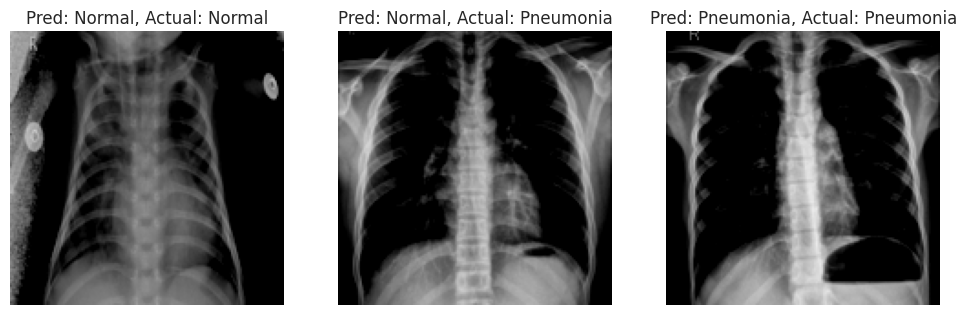


Epoch 4
Time taken: 89.85 seconds
Train -   train_loss: 0.0010  epoch_duration: 89.8548
Eval -    val_loss: 1.5909    val_f1_score: 0.8142

Predictions examples on validation set:


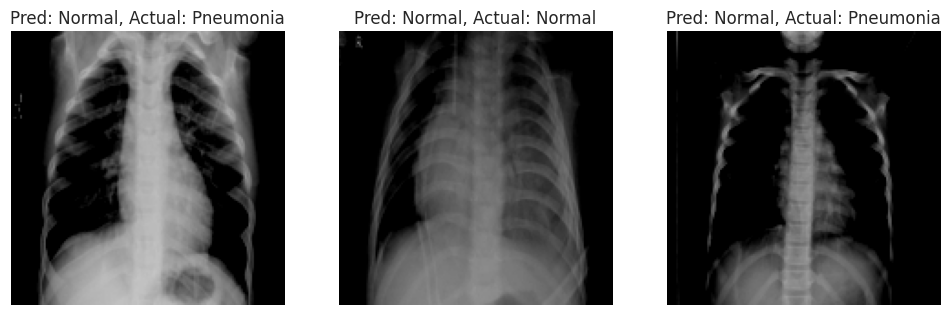


Epoch 5
Time taken: 88.57 seconds
Train -   train_loss: 0.0069  epoch_duration: 88.5743
Eval -    val_loss: 0.8454    val_f1_score: 0.8461

Predictions examples on validation set:


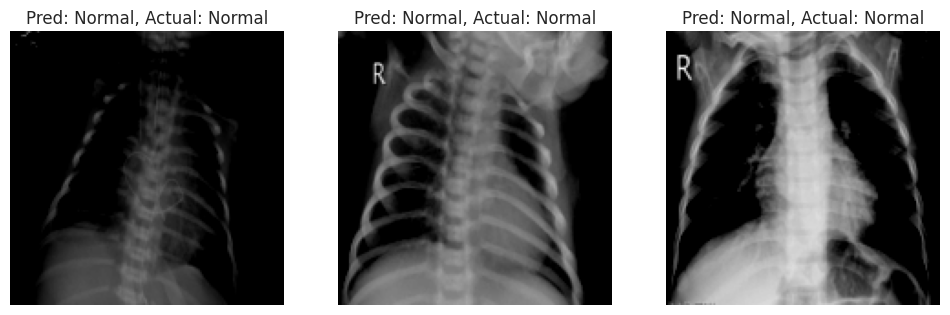


Epoch 6
Time taken: 89.82 seconds
Train -   train_loss: 0.0526  epoch_duration: 89.8182
Eval -    val_loss: 1.0946    val_f1_score: 0.8460

Predictions examples on validation set:


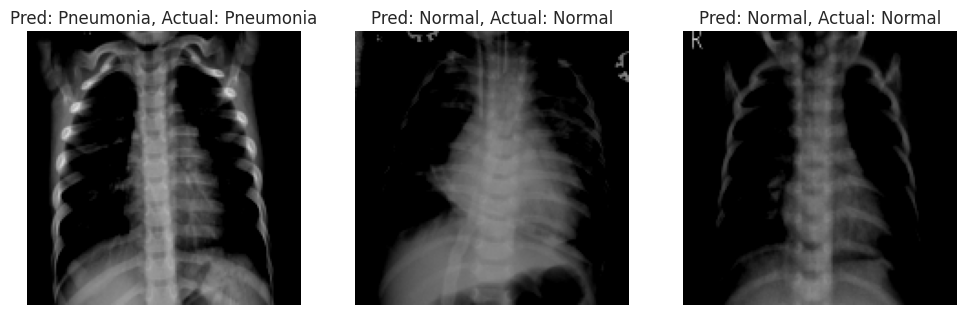


Epoch 7
Time taken: 88.49 seconds
Train -   train_loss: 0.0005  epoch_duration: 88.4863
Eval -    val_loss: 2.0203    val_f1_score: 0.8176

Predictions examples on validation set:


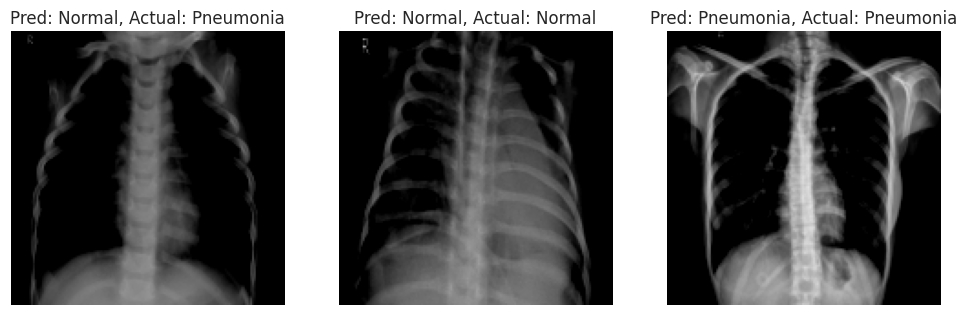


Epoch 8
Time taken: 91.19 seconds
Train -   train_loss: 0.0008  epoch_duration: 91.1886
Eval -    val_loss: 1.5344    val_f1_score: 0.8299

Predictions examples on validation set:


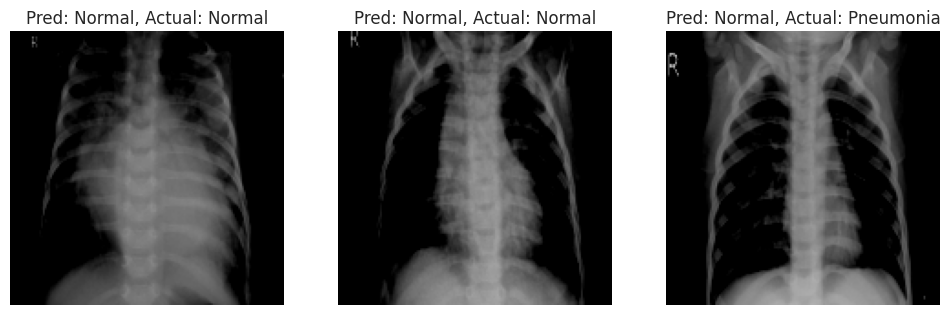


Epoch 9
Time taken: 88.69 seconds
Train -   train_loss: 0.0201  epoch_duration: 88.6926
Eval -    val_loss: 2.0209    val_f1_score: 0.8104

Predictions examples on validation set:


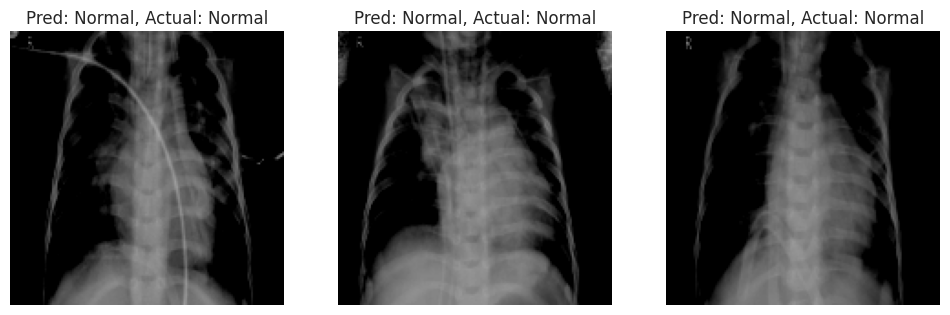


Epoch 10
Time taken: 88.90 seconds
Train -   train_loss: 0.0133  epoch_duration: 88.8960
Eval -    val_loss: 2.1612    val_f1_score: 0.8121

Predictions examples on validation set:


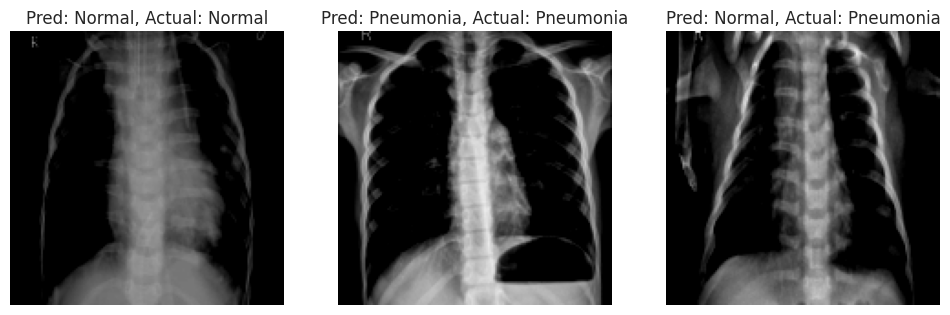


Total Training Time: 990.27 seconds


epoch_duration,▅▆▁▅▂▅▂█▃▃
train_loss,▄▄▂▁▂█▁▁▄▃
val_f1_score,█▃█▁▆▆▂▄▁▁
val_loss,▁▃▃▆▃▄▇▅▇█
epoch_duration,88.89599
train_loss,0.0133
val_f1_score,0.81211
val_loss,2.16119


In [26]:
with wandb.init(
        config=config,
        project='INF8225 - Projet',  # Title of your project
        group='Pytorch ResNet',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
    train_model(model, config)